# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발


- '2024 생명연구자원 AI활용 경진대회'는 바이오 데이터를 기반으로 한 AI 기술의 문제 해결 능력을 탐구하는 것을 목표로 합니다. <br>이 대회는 바이오 분야에서 AI 활용의 저변을 확대하고, 복잡한 바이오 데이터를 효율적으로 분석 및 해석할 수 있는 AI 알고리즘 개발에 초점을 맞추고 있습니다. <br><br>
- 본 대회의 구체적인 과제는 암환자 유전체 데이터의 변이 정보를 활용하여 암종을 분류하는 AI 모델을 개발하는 것입니다. <br>참가자들은 제공된 학습 데이터셋(암환자 유전체 변이 정보)을 사용하여 `특정 변이 정보를 바탕`으로 `암종을 정확하게 분류`할 수 있는 AI 알고리즘을 개발해야 합니다. <br><br>
- 이 대회의 궁극적인 목적은 바이오 데이터의 활용도를 높이고, 바이오 분야에서 AI 기술의 적용 가능성을 극대화하며, 인공지능 기술이 실제 바이오 의료 문제 해결에 어떻게 기여할 수 있는지 탐구하는 것입니다.

# Import library

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DACON/암환자 유전체 데이터/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON/암환자 유전체 데이터/test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6201 entries, 0 to 6200
Columns: 4386 entries, ID to ZYX
dtypes: object(4386)
memory usage: 207.5+ MB


### 데이터 설명
- ID: 각 샘플을 구분하는 고유 식별자.
- SUBCLASS: 각 샘플에 대한 암종을 나타내는 레이블 (타겟 변수).
- A2M ~ ZYX: 유전자 정보(열)가 담긴 열로, 각 열은 유전자 변이를 나타냅니다.
- WT(Wild Type)는 해당 유전자에 변이가 없음을, 그 외 값은 특정 변이가 있음을 나타냅니다.

In [ ]:
train.head()

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [ ]:
# 기술 통계 확인 : 수치형 변수의 통계 요약(평균, 표준편차, 최소값 ,최대값 등)을 확인
train.describe()

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
count,6201,6201,6201,6201,6201,6201,6201,6201,6201,6201,...,6201,6201,6201,6201,6201,6201,6201,6201,6201,6201
unique,6201,26,141,43,25,1,48,145,119,129,...,168,69,33,27,126,61,53,53,35,41
top,TRAIN_0000,BRCA,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
freq,1,786,6053,6157,6176,6201,6153,6045,6079,6069,...,6025,6131,6169,6174,6065,6139,6143,6142,6166,6159


### 결과 설명

count:

각 변수에 대한 유효한 값의 개수를 나타냅니다. 예를 들어, A2M, AAAS 등의 변수는 6201개의 값이 모두 존재함을 보여줍니다. 결측치가 없다는 의미입니다.

<br>
unique:

각 변수의 고유 값의 수를 나타냅니다. 예를 들어, SUBCLASS는 26개의 고유 값이 있고, 이는 26개의 서로 다른 암종이 존재한다는 것을 의미합니다.

<br>
top:

가장 빈도가 높은 값을 보여줍니다. 예를 들어, SUBCLASS에서 가장 많이 나타나는 값은 BRCA로, 786번 등장한 것을 보여줍니다. A2M과 같은 다른 변수는 가장 많이 나타나는 값이 WT로, 이는 변이가 없음을 나타냅니다.

<br>
freq:

top에서 나타낸 값이 얼마나 자주 등장하는지를 보여줍니다. 예를 들어, SUBCLASS의 경우 BRCA가 786번 등장하는 것을 확인할 수 있습니다.

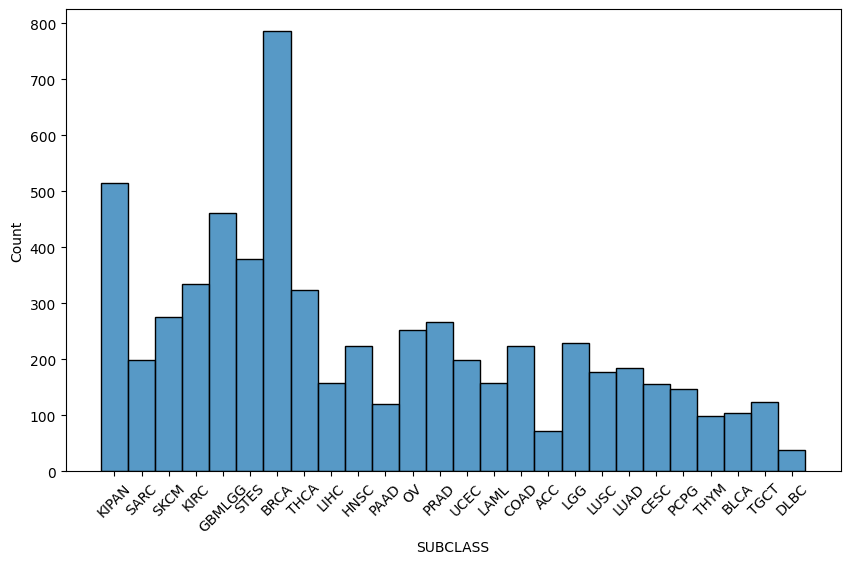

In [ ]:
# SUBCLASS열에 있는 요소 중 개수별 히스토그램
# 데이터 분포 시각화 : 히스토그램이나 박스플롯을 통해 각 변수의 분포를 시각적으로 확인합니다.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train['SUBCLASS'])
plt.xticks(rotation=45)  # x축 레이블을 45도 회전
plt.show()

In [ ]:
# 결측치 확인: isnull().sum()을 사용하여 결측치를 확인합니다.
print(train.isnull().sum())

ID          0
SUBCLASS    0
A2M         0
AAAS        0
AADAT       0
           ..
ZNRF4       0
ZPBP        0
ZW10        0
ZWINT       0
ZYX         0
Length: 4386, dtype: int64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45772 (\N{HANGUL SYLLABLE NIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

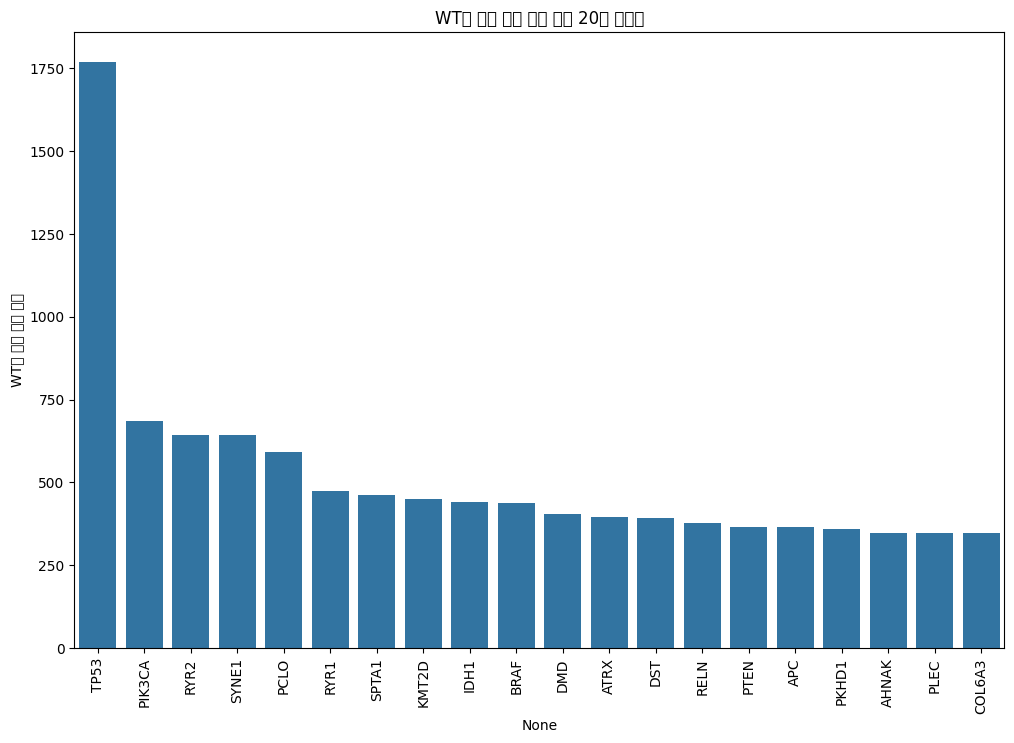

In [ ]:
'''
1. 변수의 분포 시각화
각 유전자 변이에 대해 WT가 아닌 값들이 얼마나 분포되어 있는지 시각화합니다.
이를 통해 데이터의 불균형 여부를 파악할 수 있습니다.
히스토그램이나 바 차트를 사용하여 특정 변이(예: WT가 아닌 값)가 자주 발생하는 유전자를 시각화합니다.
'''
import matplotlib.pyplot as plt
import seaborn as sns

# 각 열에 WT가 아닌 값이 있는지 확인
non_wt_data = train.loc[:, 'A2M':'ZYX'] != 'WT'

# WT가 아닌 값이 있는 열의 합계를 구함
non_wt_count = non_wt_data.sum()

# WT가 아닌 값이 많은 상위 20개 유전자를 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=non_wt_count.sort_values(ascending=False).index[:20],
            y=non_wt_count.sort_values(ascending=False).values[:20])
plt.xticks(rotation=90)
plt.title('WT가 아닌 값이 있는 상위 20개 유전자')
plt.ylabel('WT가 아닌 값의 개수')
plt.show()

WT가 아닌 값이 있는 상위 20개 유전자 중, TP53열이 WT가 아닌 값의 개수가 1750 값으로 가장 많은 값으로 측정.
<br>
-> 다음 단계로는 데이터 분석 및 모델링에서 TP53 유전자와 다른 주요 유전자들 간의 관계를 탐구하고, 이를 통해 암종 분류에 중요한 유전자를 선정하는 것이 좋습니다.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

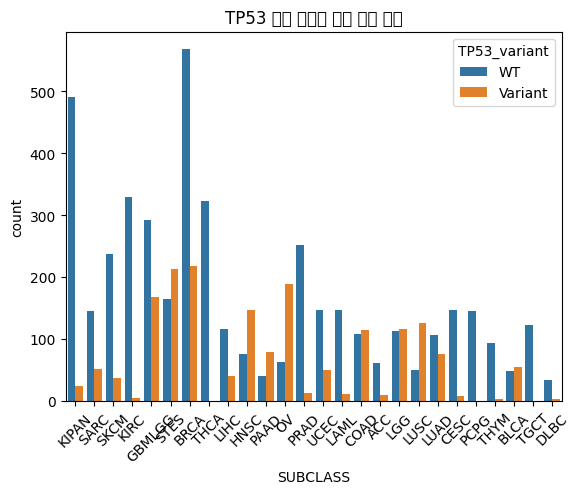

'\n[그래프 분석]\n"BRCA"와 GBM 암종에서 WT와 변이 모두 많이 관찰됩니다.\nSARC, SKCM, LUSC 등 몇몇 암종에서 변이가 상대적으로 더 많이 관찰됩니다.\nESCA, HNSC, LUAD 등은 변이와 WT 모두 고르게 분포되어 있습니다.\n'

In [ ]:
# TP53 변이 여부에 따른 암종 분포 시각화
train['TP53_variant'] = train['TP53'].apply(lambda x: 'WT' if x == 'WT' else 'Variant')
sns.countplot(data=train, x='SUBCLASS', hue='TP53_variant')
plt.xticks(rotation=45)
plt.title('TP53 변이 여부에 따른 암종 분포')
plt.show()

'''
TP53 유전자 변이가 암종 분류에 얼마나 중요한지 파악할 수 있습니다.
TP53 변이 값과 각 암종 간의 연관성을 시각화하거나 통계적으로 분석해보세요.
TP53과 SUBCLASS 간의 상관관계를 확인하는 것이 좋습니다. 이를 위해 TP53 변이를 기준으로 데이터를 그룹화해보세요.
예를 들어, TP53 변이가 있는 데이터와 없는 데이터를 나눠 암종 분포 차이를 확인합니다.
'''

'''
[그래프 분석]
"BRCA"와 GBM 암종에서 WT와 변이 모두 많이 관찰됩니다.
SARC, SKCM, LUSC 등 몇몇 암종에서 변이가 상대적으로 더 많이 관찰됩니다.
ESCA, HNSC, LUAD 등은 변이와 WT 모두 고르게 분포되어 있습니다.
'''

In [ ]:
# 4. TP53 변이 여부와 암종 간의 통계적 관계 분석 (카이제곱 검정)
contingency_table = pd.crosstab(train['SUBCLASS'], train['TP53'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test: p-value = {p}")

if p < 0.05:
    print("TP53 변이와 암종 간에 유의미한 상관관계가 있습니다.")
else:
    print("TP53 변이와 암종 간에 유의미한 상관관계가 없습니다.")

Chi-Square Test: p-value = 2.1858101225043587e-39
TP53 변이와 암종 간에 유의미한 상관관계가 있습니다.


<ipython-input-12-a5eb8c1e14c9>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_top_20 = X_top_20.applymap(lambda x: 0 if x == 'WT' else 1)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45772 (\N{HANGUL SYLLABLE NIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core

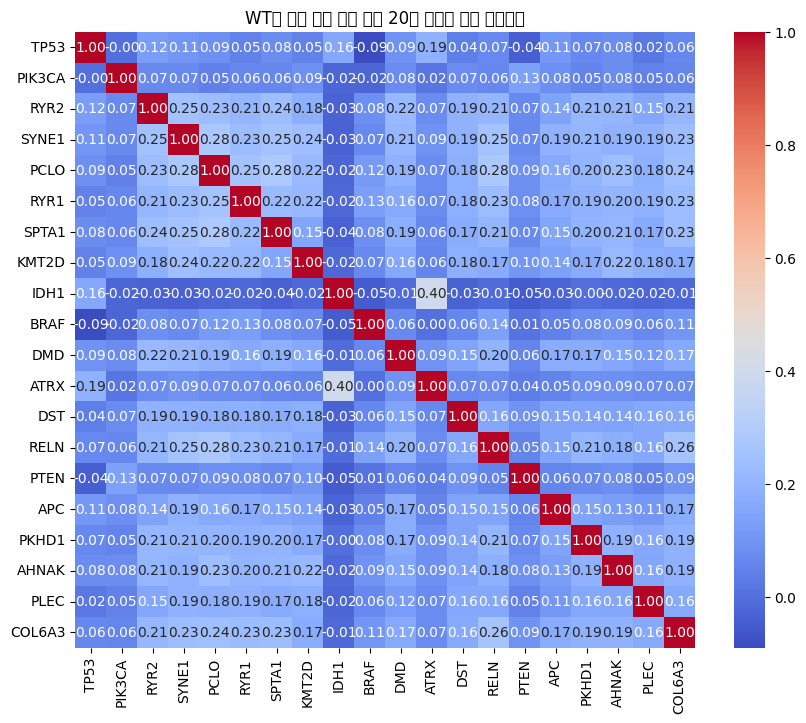

'\n[히트맵 분석]\n현재 제공된 히트맵은 WT가 아닌 값이 있는 상위 20개 유전자 간의 상관관계를 보여줍니다.\n이 상관관계 히트맵을 통해 각 유전자 간 변이 패턴이 얼마나 비슷하게 나타나는지 분석할 수 있습니다. 이를 자세히 분석하면 다음과 같습니다:\n\n1. TP53 유전자\nTP53은 그래프 상에서 다른 유전자들과 거의 상관관계가 없습니다.\n대부분의 유전자와 상관계수가 0에 가까운 것으로 나타나며, 특히 PIK3CA 및 "BRAF" 등과는 음의 상관관계를 보이고 있습니다.\n이는 TP53 변이가 독립적으로 발생하거나, 다른 유전자의 변이와는 연관성이 낮다는 것을 나타냅니다.\nTP53 변이는 암에서 매우 중요한 유전자 중 하나로 알려져 있기 때문에, 이 유전자의 독립적인 특성을 고려하여 암종 분류에서 독립 변수로 사용하는 것이 좋습니다.\n\n2. RYR1, SYNE1, RYR2의 상관관계\nRYR1, RYR2, SYNE1은 상관관계가 상대적으로 높은 편입니다. 이들 간의 상관계수는 약 0.25~0.28로, 다른 유전자들에 비해 상호간의 변이 패턴이 비슷하게 나타날 가능성이 있습니다.\n이 상관관계는 특정 암종에서 공통적으로 변이가 일어날 가능성을 시사합니다. 이들 유전자 그룹은 암종 분류에서 함께 고려해볼 만합니다.\n\n3. IDH1과 ATRX의 높은 상관관계\nIDH1과 ATRX는 상관계수가 0.40으로 상대적으로 높은 상관관계를 보여줍니다.\n이 두 유전자는 실제로 뇌종양 등 특정 암종에서 자주 함께 변이가 나타나는 것으로 알려져 있으며, 이 결과는 이를 반영한 것으로 보입니다.\n이 상관관계를 바탕으로 IDH1과 ATRX가 동시에 변이하는 환자군을 따로 분석하거나 이 두 유전자를 암종 분류에 중요한 특징으로 활용할 수 있습니다.\n\n4. 다른 유전자 간의 미미한 상관관계\n그 외 유전자 간 상관계수는 대부분 0에 가깝거나, -0.2~0.2 범위에 분포하고 있습니다.\n이는 대다수의 유전자들이 독립적으로 변이가 일어나고 있음을 나타냅니다

In [ ]:
'''
[TP53 유전자와 다른 주요 유전자들 간의 관계를 탐구하는 방법]
1. TP53 변이와 상위 20개 유전자의 변이 간의 상관 관계를 분석
: 이를 통해 TP53과 변이가 함께 발생하는 다른 유전자를 찾을 수 있습니다.

2. 상위 20개 유전자 중 암종 분류에 중요한 유전자 선별
: 상관관계 분석을 통해 암종 분류에 유의미한 영향을 미치는 유전자들을 선택할 수 있습니다.

3. 선택된 유전자들을 기반으로 특징 선택(feature selection)
: 모델에 반영할 중요한 유전자를 선정하고, 이를 통해 암종을 분류하는 모델을 개선할 수 있습니다.
'''

# 상위 20개의 주요 유전자 중에서 WT가 아닌 값이 있는 유전자 리스트
top_20_genes = ['TP53', 'PIK3CA', 'RYR2', 'SYNE1', 'PCLO', 'RYR1', 'SPTA1', 'KMT2D', 'IDH1', 'BRAF',
                'DMD', 'ATRX', 'DST', 'RELN', 'PTEN', 'APC', 'PKHD1', 'AHNAK', 'PLEC', 'COL6A3']

# TP53와 상위 유전자들의 데이터만 선택
X_top_20 = train[top_20_genes].copy()

# 'WT'를 0으로, 다른 변이 값을 1로 변환
X_top_20 = X_top_20.applymap(lambda x: 0 if x == 'WT' else 1)

# TP53과 다른 유전자 간의 상관 관계 분석
corr_matrix = X_top_20.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('WT가 아닌 값이 있는 상위 20개 유전자 간의 상관관계')
plt.show()

'''
[히트맵 분석]
현재 제공된 히트맵은 WT가 아닌 값이 있는 상위 20개 유전자 간의 상관관계를 보여줍니다.
이 상관관계 히트맵을 통해 각 유전자 간 변이 패턴이 얼마나 비슷하게 나타나는지 분석할 수 있습니다. 이를 자세히 분석하면 다음과 같습니다:

1. TP53 유전자
TP53은 그래프 상에서 다른 유전자들과 거의 상관관계가 없습니다.
대부분의 유전자와 상관계수가 0에 가까운 것으로 나타나며, 특히 PIK3CA 및 "BRAF" 등과는 음의 상관관계를 보이고 있습니다.
이는 TP53 변이가 독립적으로 발생하거나, 다른 유전자의 변이와는 연관성이 낮다는 것을 나타냅니다.
TP53 변이는 암에서 매우 중요한 유전자 중 하나로 알려져 있기 때문에, 이 유전자의 독립적인 특성을 고려하여 암종 분류에서 독립 변수로 사용하는 것이 좋습니다.

2. RYR1, SYNE1, RYR2의 상관관계
RYR1, RYR2, SYNE1은 상관관계가 상대적으로 높은 편입니다. 이들 간의 상관계수는 약 0.25~0.28로, 다른 유전자들에 비해 상호간의 변이 패턴이 비슷하게 나타날 가능성이 있습니다.
이 상관관계는 특정 암종에서 공통적으로 변이가 일어날 가능성을 시사합니다. 이들 유전자 그룹은 암종 분류에서 함께 고려해볼 만합니다.

3. IDH1과 ATRX의 높은 상관관계
IDH1과 ATRX는 상관계수가 0.40으로 상대적으로 높은 상관관계를 보여줍니다.
이 두 유전자는 실제로 뇌종양 등 특정 암종에서 자주 함께 변이가 나타나는 것으로 알려져 있으며, 이 결과는 이를 반영한 것으로 보입니다.
이 상관관계를 바탕으로 IDH1과 ATRX가 동시에 변이하는 환자군을 따로 분석하거나 이 두 유전자를 암종 분류에 중요한 특징으로 활용할 수 있습니다.

4. 다른 유전자 간의 미미한 상관관계
그 외 유전자 간 상관계수는 대부분 0에 가깝거나, -0.2~0.2 범위에 분포하고 있습니다.
이는 대다수의 유전자들이 독립적으로 변이가 일어나고 있음을 나타냅니다. 다시 말해, 이 유전자들은 특정 유전자가 변이를 일으킬 때 다른 유전자도 같이 변이하는 패턴이 적다는 것을 보여줍니다.

5. 특정 음의 상관관계
몇몇 유전자 쌍 간에는 음의 상관관계가 존재합니다. 예를 들어, TP53과 BRAF의 상관계수는 -0.09로 나타났습니다. 이는 한 유전자에서 변이가 발생할 때 다른 유전자에서는 변이가 덜 발생하는 경향이 있음을 시사합니다.
이런 음의 상관관계는 변이 패턴이 서로 상반되는 유전자들이 있음을 나타내며, 이를 모델링할 때 함께 고려하면 예측 성능을 향상시킬 수 있습니다.

6. 분석의 의미
유전자 간의 변이 패턴 파악: 상관관계가 높은 유전자들은 함께 변이하는 경향이 있기 때문에 암종 분류에 있어 중요한 역할을 할 수 있습니다.
이러한 유전자들을 중심으로 특징 선택(feature selection)을 하면 더 나은 모델을 만들 수 있습니다.

독립적인 변이: 상관계수가 낮은 유전자들은 암종 분류에서 독립적인 변이로 작용할 가능성이 크므로,
이를 단독으로 분석하거나 모델에 추가적으로 반영할 수 있습니다.

음의 상관관계: 음의 상관관계를 보이는 유전자들은 서로 대조적인 변이 패턴을 보일 수 있어, 특정 암종에서 중요한 정보로 작용할 수 있습니다.
'''

<ipython-input-13-3da2217bb3b0>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_idh_atrx = X_idh_atrx.applymap(lambda x: 0 if x == 'WT' else 1)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

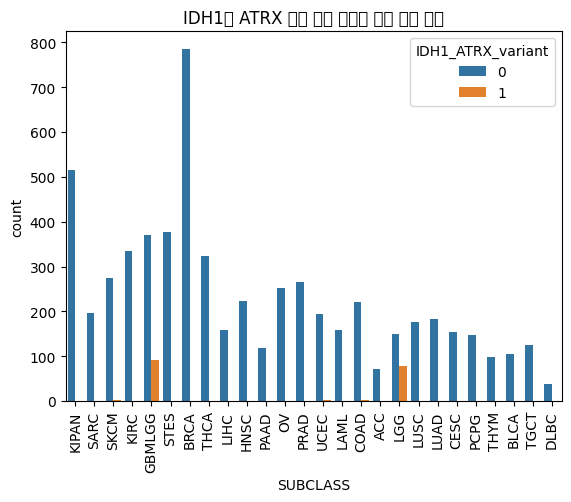

'\n[그래프 분석]\nGBMLGG 암종에서 IDH1과 ATRX의 동시 변이가 집중적으로 발생하고 있는 것을 볼 수 있습니다.\n이는 GBMLGG에서 이 두 유전자의 변이가 중요한 역할을 할 수 있음을 나타냅니다.\n나머지 암종에서는 **동시 변이(1)**가 거의 발생하지 않으며,\n대부분의 샘플에서 IDH1과 ATRX가 독립적으로 변이하거나 변이가 없는(0) 상태입니다.\n이러한 결과는 IDH1과 ATRX의 동시 변이가 특정 암종(예: GBMLGG)에만 주로 나타난다는 것을 시사합니다.\n이는 실제로도 알려진 사실로, IDH1과 ATRX는 주로 뇌종양에서 변이를 일으키는 유전자입니다.\n'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# IDH1과 ATRX 유전자 데이터 추출
X_idh_atrx = train[['IDH1', 'ATRX']].copy()

# 'WT'를 0으로, 다른 변이 값을 1로 변환
X_idh_atrx = X_idh_atrx.applymap(lambda x: 0 if x == 'WT' else 1)

# IDH1과 ATRX가 동시에 변이하는 샘플을 구분하는 새로운 열 생성
X_idh_atrx['IDH1_ATRX_variant'] = (X_idh_atrx['IDH1'] == 1) & (X_idh_atrx['ATRX'] == 1)

# 새로운 특징 열 추가 (동시 변이가 있을 경우 1, 없을 경우 0)
X_idh_atrx['IDH1_ATRX_variant'] = X_idh_atrx['IDH1_ATRX_variant'].astype(int)

# IDH1_ATRX 변이 여부에 따른 암종 분포 시각화
sns.countplot(data=train, x='SUBCLASS', hue=X_idh_atrx['IDH1_ATRX_variant'])
plt.title('IDH1과 ATRX 동시 변이 여부에 따른 암종 분포')
plt.xticks(rotation=90)
plt.show()

'''
[그래프 분석]
GBMLGG 암종에서 IDH1과 ATRX의 동시 변이가 집중적으로 발생하고 있는 것을 볼 수 있습니다.
이는 GBMLGG에서 이 두 유전자의 변이가 중요한 역할을 할 수 있음을 나타냅니다.
나머지 암종에서는 **동시 변이(1)**가 거의 발생하지 않으며,
대부분의 샘플에서 IDH1과 ATRX가 독립적으로 변이하거나 변이가 없는(0) 상태입니다.
이러한 결과는 IDH1과 ATRX의 동시 변이가 특정 암종(예: GBMLGG)에만 주로 나타난다는 것을 시사합니다.
이는 실제로도 알려진 사실로, IDH1과 ATRX는 주로 뇌종양에서 변이를 일으키는 유전자입니다.
'''

# TP53변이를 모델 중요한 피처로 사용할 경우
-> 성능 너무 낮음
성능 : 0.30

In [ ]:
# from imblearn.over_sampling import SMOTE  # 여기에서 SMOTE를 임포트


# # 2. 레이블 인코더 생성
# le_subclass = LabelEncoder()

# # 3. 타겟 변수(SUBCLASS)를 숫자로 인코딩
# train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# # 4. X와 y 분리
# X = train.drop(columns=['ID', 'SUBCLASS'])
# X = X.applymap(lambda x: 0 if x == 'WT' else 1)  # 변이 여부 변환
# y = train['SUBCLASS']

# # 테스트 데이터 전처리
# X_test = test.drop(columns=['ID'])
# X_test = X_test.applymap(lambda x: 0 if x == 'WT' else 1)

# # 5. 모델 훈련 및 예측
# # SMOTE 및 데이터 분할, 모델 학습 등 기존 코드 유지
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)
# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # 6. 모델 성능 평가
# y_pred = rf_model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)
# print(f"Validation Accuracy: {accuracy}")
# print(classification_report(y_val, y_pred))


<ipython-input-32-d7dc350f76a9>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 0 if x == 'WT' else 1)  # 변이 여부 변환
<ipython-input-32-d7dc350f76a9>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = X_test.applymap(lambda x: 0 if x == 'WT' else 1)


Validation Accuracy: 0.3013698630136986
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       172
           1       0.63      0.22      0.33       147
           2       0.36      0.22      0.27       157
           3       0.55      0.07      0.13       160
           4       0.77      0.65      0.70       164
           5       0.59      0.37      0.45       163
           6       0.12      0.04      0.06       155
           7       0.41      0.15      0.22       156
           8       0.05      0.02      0.03       166
           9       0.37      0.31      0.34       151
          10       0.79      0.29      0.43       151
          11       0.51      0.56      0.54       160
          12       0.46      0.18      0.26       162
          13       0.51      0.25      0.34       154
          14       0.44      0.18      0.26       168
          15       0.25      0.08      0.12       163
          16       0.26      0.39      0.

# 유전자별 중요한 피처 분석 및 성능평가

# 중요도 높은 유전자 찾기

In [ ]:
# # 2. 라벨 인코더를 사용해 타겟 변수(SUBCLASS)를 인코딩
# le_subclass = LabelEncoder()
# train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# # 3. 전체 유전자 피처 선택 (ID, SUBCLASS 제외한 모든 유전자 열 사용)
# X = train.drop(columns=['ID', 'SUBCLASS'])
# X = X.applymap(lambda x: 0 if x == 'WT' else 1)  # 변이 여부를 0과 1로 변환
# y = train['SUBCLASS']

# # 4. 데이터 분할 (훈련, 검증)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # 5. 랜덤 포레스트 모델 학습
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # 6. 피처 중요도 계산
# importances = rf_model.feature_importances_
# feature_importances = pd.DataFrame({'Gene': X.columns, 'Importance': importances})
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# # 7. 중요도가 높은 유전자 출력
# print("Feature Importances:")
# print(feature_importances.head(20))  # 상위 20개의 중요 유전자 출력

<ipython-input-51-ecddf6308c6c>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 0 if x == 'WT' else 1)  # 변이 여부를 0과 1로 변환


Feature Importances:
              Gene  Importance
474           BRAF    0.024254
1888          IDH1    0.019793
4280           VHL    0.016845
2977        PIK3CA    0.012988
4384  TP53_variant    0.012027
251            APC    0.010634
3223          PTEN    0.005280
2712          NPM1    0.005277
384           ATRX    0.005267
1551         GATA3    0.004217
700           CDH1    0.003938
979         CTNNB1    0.003854
1243          EGFR    0.003381
2857          PCLO    0.002837
3795          SPOP    0.002763
2302        MAP3K1    0.002750
3907         SYNE1    0.002711
3469          RYR2    0.002402
724         CDKN2A    0.002315
2151         KMT2D    0.002218


BRAF, IDH1, VHL, PIK3CA, TP53_variant, APC와 같은 유전자가 높은 중요도를 가지고 있으며, 특히 BRAF와 IDH1은 중요한 역할을 하는 것으로 나타났습니다.